# Anomaly Detection in IoT Sensor Data (Task 1)

**Module:** DLBDSMTP01  
**Student:** Moses Holl
**StudentID:** 42302677
**Date:** 08.12.2025  

---

## 1. Project Overview

Goal: Design a simple anomaly detection system for IoT sensors in a factory-like environment.

We use a synthetic IoT dataset with:
- Sensor features: Temperature, Humidity, Battery_Level  
- Target: Anomaly (0 = normal, 1 = anomalous behaviour)

This notebook covers:
1. Loading and exploring the dataset  
2. Preparing data for modeling  
3. Training and evaluating an anomaly detection model  
4. Saving the model for later use in a REST API


In [6]:
from google.colab import files

uploaded = files.upload()


Saving synthetic_iot_dataset_challenging.csv to synthetic_iot_dataset_challenging (1).csv


## 2. Import libraries and load the dataset

We first import the required Python libraries and load the IoT dataset  
(`synthetic_iot_dataset_challenging.csv`) that we uploaded to Colab.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

import joblib  # for saving the trained model

# Load the dataset (file already uploaded in Colab)
df = pd.read_csv("synthetic_iot_dataset_challenging.csv")

print("First 5 rows:")
display(df.head())

print("\nColumns:")
print(df.columns)

print("\nInfo:")
print(df.info())



First 5 rows:


,Device_ID,Temperature,Humidity,Battery_Level,Anomaly
0,DHT11_B,-0.555734,-0.157264,0.377032,0
1,DHT11_A,-0.266879,-0.086229,-0.217410,0
2,DHT11_B,0.128544,0.041150,0.090479,0
3,DHT11_D,-1.001516,-0.320621,-0.705341,0
4,DHT11_D,0.311015,0.115365,0.807002,0



Columns:
Index(['Device_ID', 'Temperature', 'Humidity', 'Battery_Level', 'Anomaly'], dtype='object')

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Device_ID      3000 non-null   object 
 1   Temperature    3000 non-null   float64
 2   Humidity       3000 non-null   float64
 3   Battery_Level  3000 non-null   float64
 4   Anomaly        3000 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 117.3+ KB
None


## 3. Exploratory Data Analysis (EDA)

We check:
- Class balance of the anomaly label  
- Summary statistics of the sensor features  
- Any missing values  
- Simple distributions for the main features


In [10]:
# Rename 'Anomaly' to 'is_anomaly' for clarity
df = df.rename(columns={"Anomaly": "is_anomaly"})

print("Class balance (counts):")
print(df["is_anomaly"].value_counts())

print("\nClass balance (%):")
print(df["is_anomaly"].value_counts(normalize=True) * 100)

print("\nDescriptive statistics for sensors:")
display(df[["Temperature", "Humidity", "Battery_Level"]].describe())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nAnomaly rate by device:")
print(df.groupby("Device_ID")["is_anomaly"].mean())



Class balance (counts):
is_anomaly
0    2478
1     522
Name: count, dtype: int64

Class balance (%):
is_anomaly
0    82.6
1    17.4
Name: proportion, dtype: float64

Descriptive statistics for sensors:


,Temperature,Humidity,Battery_Level
count,3000.000000,3000.000000,3000.000000
mean,-0.239181,-0.072275,-0.008572
std,0.695724,0.212487,0.886125
min,-3.450221,-1.096073,-2.853909
25%,-0.673384,-0.197956,-0.584657
50%,-0.196133,-0.058163,-0.103533
75%,0.235302,0.067499,0.511084
max,2.230085,0.702441,3.644408



Missing values per column:
Device_ID        0
Temperature      0
Humidity         0
Battery_Level    0
is_anomaly       0
dtype: int64

Anomaly rate by device:
Device_ID
DHT11_A    0.180837
DHT11_B    0.185185
DHT11_C    0.168597
DHT11_D    0.161157
Name: is_anomaly, dtype: float64


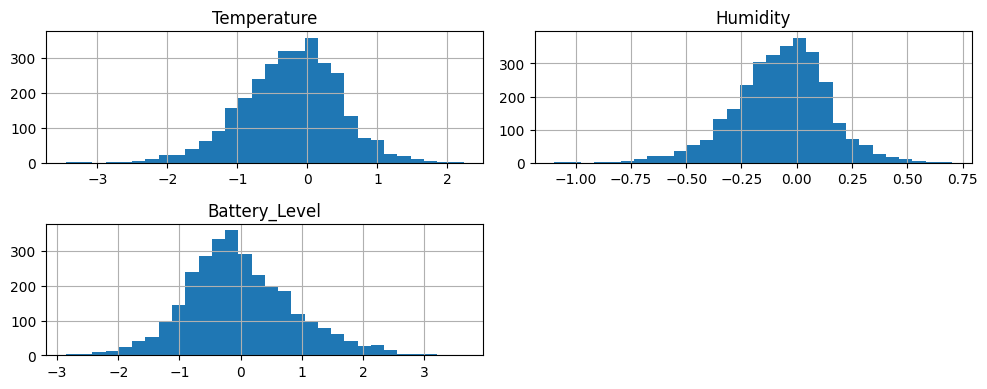

In [11]:
# Simple histograms of the sensor features
df[["Temperature", "Humidity", "Battery_Level"]].hist(bins=30, figsize=(10, 4))
plt.tight_layout()
plt.show()


## 4. Data preparation for modeling

We now:
- Select the three sensor features as input (X)  
- Use `is_anomaly` as the target (y)  
- Split the data into training and test sets  
- Standardize the features and train a model using a scikit-learn Pipeline


In [12]:
# Features and target
feature_cols = ["Temperature", "Humidity", "Battery_Level"]
target_col = "is_anomaly"

X = df[feature_cols]
y = df[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (2400, 3) Test shape: (600, 3)


## 5. Model training and evaluation

We train a baseline classifier using a Pipeline:

- StandardScaler: normalizes the three sensor features  
- RandomForestClassifier: robust tree-based classifier

We then evaluate the model using:
- Classification report (precision, recall, F1-score)  
- Confusion matrix


In [17]:
# Define a pipeline: scaling + random forest
model = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            class_weight="balanced"  # useful if classes are imbalanced
        )),
    ]
)

# Fit the model
model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

In [14]:
# Predictions on test set
y_pred = model.predict(X_test)

print("Classification report on test set:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


Classification report on test set:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       496
           1       0.51      0.40      0.45       104

    accuracy                           0.83       600
   macro avg       0.70      0.66      0.68       600
weighted avg       0.82      0.83      0.82       600

Confusion matrix:
[[456  40]
 [ 62  42]]


## 6. Save the trained model

We save the fitted Pipeline (scaler + classifier) using `joblib`.  
This file can later be loaded inside a REST API to score new sensor readings.


In [16]:
# Retrain on full dataset
model.fit(X, y)

# Save model to disk
model_filename = "iot_anomaly_model.joblib"
joblib.dump(model, model_filename)

print(f"Model saved to: {model_filename}")


Model saved to: iot_anomaly_model.joblib


## 7. Summary of modeling in Colab & next steps

In this notebook we have:

- Loaded the synthetic IoT sensor dataset (`synthetic_iot_dataset_challenging.csv`).
- Performed basic EDA:
  - Checked class balance of the anomaly label.
  - Inspected descriptive statistics of `Temperature`, `Humidity`, and `Battery_Level`.
  - Plotted simple distributions for the main features.
- Prepared the data for modeling:
  - Renamed `Anomaly` → `is_anomaly`.
  - Selected the three sensor features as inputs: `Temperature`, `Humidity`, `Battery_Level`.
  - Created feature matrix `X` and target vector `y`.
  - Split the data into training and test sets.
- Trained a baseline anomaly detection model using a scikit-learn `Pipeline`
  (StandardScaler + RandomForestClassifier).
- Evaluated the model on the test set with a classification report and confusion matrix.
- Saved the trained pipeline to `iot_anomaly_model.joblib` for reuse in a separate application.

The remaining steps (deployment) will be implemented **outside of Colab**:

- Build a small REST API (e.g. with Flask or FastAPI) that:
  - loads `iot_anomaly_model.joblib`,
  - exposes a `/predict` endpoint that accepts JSON sensor readings,
  - returns anomaly predictions and anomaly probabilities.
- Optionally create a simple "sensor stream" script that sends rows from the dataset
  to the API to simulate real-time IoT data.
- Publish the API code, the saved model file, and this notebook in a public repository
  (), including a `README.md` with:
  - the project goal,
  - how to run the API,
  - how to reproduce the results from this notebook.

Thus, this notebook documents the **data & modeling part**, and the external repository
will document the **system architecture & deployment part**.
